## Random Forest Regression


In [4]:
import pandas as pd
df = pd.read_csv('../raw_data/df_grouped_rate.csv') #폴더 위치는 상이할 수 있음


In [5]:
y=df.iloc[:,3:4]
# y

In [6]:
X= df.iloc[:,1:].drop(['sales_total'],axis=1)
# X

In [7]:
# 더미변수화
X_dum1 = pd.get_dummies(X.iloc[:,0])  #district는 범주형으로 인식 안해서 따로 실시
X_dum2 = pd.get_dummies(X.iloc[:,1:])
X = pd.concat([X_dum1, X_dum2],axis=1)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # y 값이 정의되지 않아 df.sales_total 으로 대체하겠습니다.
# 로버스트 스케일링
rb = RobustScaler()
Xs_train = rb.fit_transform(X_train)
Xs_test = rb.transform(X_test)

In [49]:

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=30,max_depth=10, random_state=0)
model=regr.fit(Xs_train, y_train)
y_pred=regr.predict(Xs_test)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [50]:
# 정확도 결과값
print(model.score(Xs_train, y_train))
print(model.score(Xs_test, y_test))
# 오차 결과값
from sklearn import metrics
y_pred = model.predict(Xs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.6975131778848385
0.6055144857365033
Mean Absolute Error: 529656349.2633514
Mean Squared Error: 1.0646257046839917e+18
Root Mean Squared Error: 1031807009.4179394


In [51]:
from sklearn.metrics import r2_score
print("R-Squared score:", r2_score(y_test , y_pred))

R-Squared score: 0.6055144857365033


In [52]:
y_pred

array([5.48037056e+08, 6.17190617e+08, 3.49552996e+08, ...,
       3.61597754e+08, 9.71399692e+07, 6.36449815e+08])

In [53]:
yy_test=np.array(y_test).reshape(-1,)

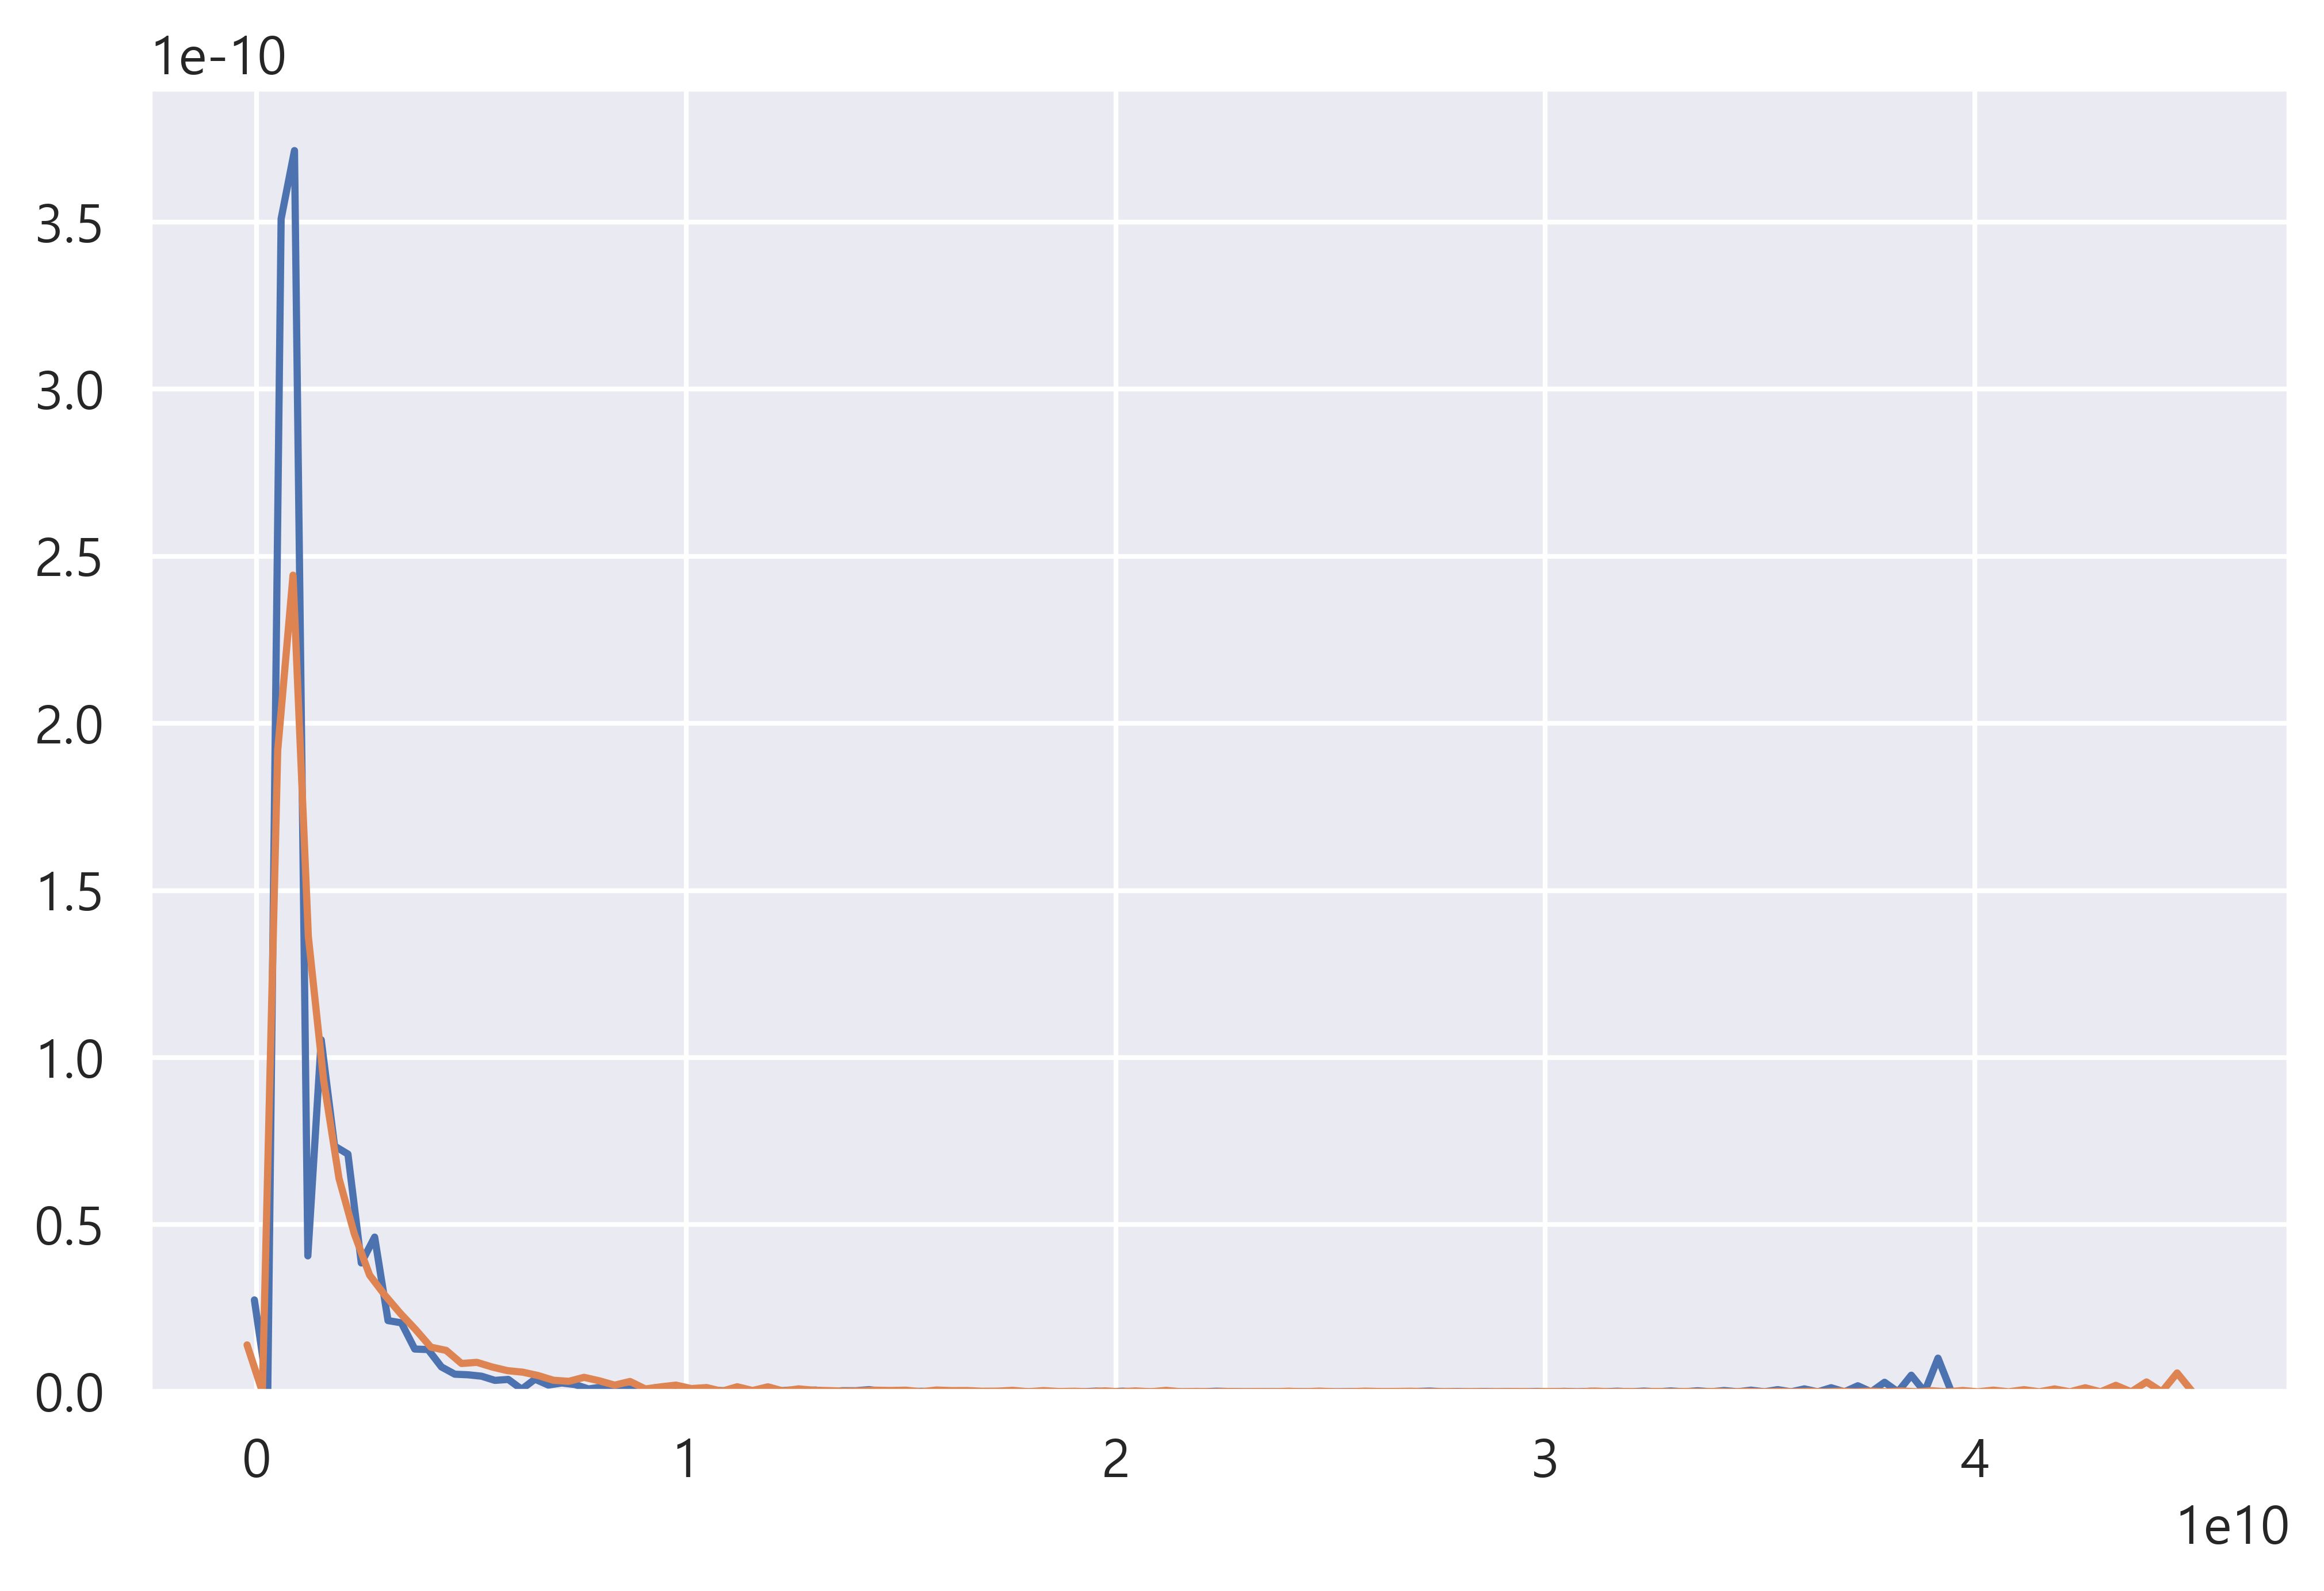

In [54]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)


sns.kdeplot(y_pred)
sns.kdeplot(yy_test)
# plt.title("")
plt.show()

### LightGBM 이용
-참고 블로그
> http://machinelearningkorea.com/2019/05/18/lightgbm%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%9A%8C%EA%B7%80%EC%98%88%EC%B8%A1-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%B9%98%ED%8A%B8%EC%BD%94%EB%93%9C/ 


### parameter
max_depth : 나무의 깊이. 단일 결정나무에서는 충분히 데이터를 고려하기 위해 depth를 적당한 깊이로 만들지만, 부스팅에서는 깊이 하나짜리도 만드는 등, 깊이가 짧은것이 크리티컬하지 않다. 어차피 보정되니까..

min_data_in_leaf : 한 잎사귀 노드에 들어갈수 있는 데이터의 갯수.

feature_fraction : 부스팅 대상 모델이 랜덤포레스트일때, 랜덤포레스트는 feature의 일부만을 선택하여 훈련하는데, 이를 통제하기 위한 파라미터.

bagging_fraction : 데이터의 일부만을 사용하는 bagging의 비율이다. 예를들어 오버피팅을 방지하기 위해 데이터의 일부만을 가져와서 훈련시키는데, 이는 오버피팅을 방지하며 약한예측기를 죄다 합칠경우는 오히려 예측성능이 좋아질것이다.

early_stopping_round : 더이상 validation데이터에서 정확도가 좋아지지 않으면 멈춰버린다. 훈련데이터는 거의 에러율이 0에 가깝게 좋아지기 마련인데, validation데이터는 훈련에 사용되지 않기때문에 일정이상 좋아지지 않기 때문이다. 이후 진행하게 되면 컴퓨터 재능낭비다.

lambda : 정규화에 사용되는 파라미터

min_gain_to_split : 최소 정보이득이 있어야 분기가 되게끔 만든다.

max_cat_group : 범주형 변수가 많으면, 하나로 퉁쳐서 처리하게끔 만드는 최소단위.

objective : lightgbm은 regression, binary, multicalss 모두 가능

boosting: gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)

num_leaves: 결정나무에 있을 수 있는 최대 잎사귀 수. 기본값은 0.31

learning_rate : 상당히 중요한 파라미터인데, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 만든다. learning_rate은 아래의 num_boost_round와 잘 맞춰져야 ㅎ나다.

num_boost_round : boosting을 얼마나 돌릴지 지정한다. 경험상 보통 100정도면 너무 빠르게 끝나며, 시험용이 아니면 1000정도는 준다. 어차피 early_stopping_round가 지정되어있으면 더이상 진전이 없을경우 알아서 멈춘다.

device : gpu, cpu

metric: loss를 측정하기 위한 기준. mae (mean absolute error), mse (mean squared error), 등등이 있다. 사실 엄청많다.

max_bin : 최대 bin

categorical_feature : 범주형 변수가 있을때 여기에 언급해준다. 다만, categorical은 string은 쓸수 없는것으로 보인다.

ignore_column : 컬럼을 무시한다. 무시하지 않을경우 모두 training에 넣는데, 뭔가 남겨놓아야할 컬럼이 있으면 여기다가 인자를 준다.

save_binary: True로 해놓으면 메모리를 아낀다.



출처: https://gorakgarak.tistory.com/1285 [먹거리 만드는 열정맨 고락가락]

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
train_ds = lgb.Dataset(train_x, label = train_y) 
test_ds = lgb.Dataset(test_x, label = test_y) 

params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}


In [9]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.39036e+18
[200]	valid_0's l2: 1.11323e+18
[300]	valid_0's l2: 1.02178e+18
[400]	valid_0's l2: 9.72203e+17
[500]	valid_0's l2: 9.45311e+17
[600]	valid_0's l2: 9.287e+17
[700]	valid_0's l2: 9.15815e+17
[800]	valid_0's l2: 9.08078e+17
[900]	valid_0's l2: 8.98034e+17
[1000]	valid_0's l2: 8.89401e+17
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 8.89401e+17


In [11]:
y_pred = model.predict(test_x)

In [12]:
# 에러 측정
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  8.894014625311738e+17
R2 score:  0.6704419292248263


In [14]:

# 오차 결과값
from sklearn import metrics
y_pred = model.predict(test_x)
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 439373570.0080398
Mean Squared Error: 8.894014625311738e+17
Root Mean Squared Error: 943080835.6292549


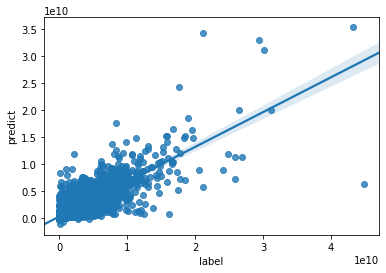

In [15]:
final_result = pd.concat([test_y.reset_index(drop=True), pd.DataFrame(y_pred)], axis = 1)
final_result.columns = ['label','predict']

sns.regplot(x = 'label', y = 'predict', data = final_result)

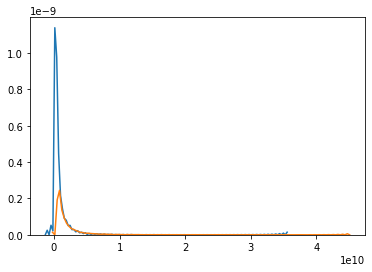

In [17]:
import matplotlib.pyplot as plt
sns.kdeplot(y_pred)
sns.kdeplot(np.array(test_y).reshape(-1,))
# plt.title("")
plt.show()